In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

[6]


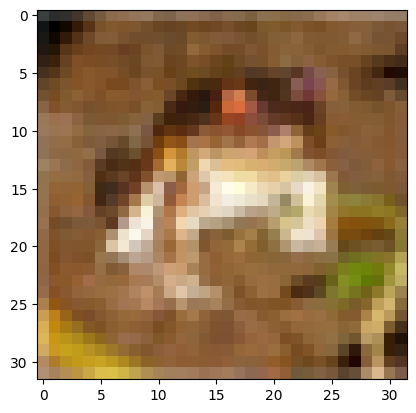

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32))).batch(128)

In [3]:
# example: two (basic) inception blocks
# TODO: add 1x1 convs ;)
inputs = tf.keras.layers.Input((32, 32, 3))


conv1_1 = tf.keras.layers.Conv2D(32, 1, activation=tf.nn.relu, padding="same",
                                 name="conv1_1x1")(inputs)
conv1_3 = tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same",
                                 name="conv1_3x3")(inputs)
conv1_5 = tf.keras.layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same",
                                 name="conv1_5x5")(inputs)
pool1 = tf.keras.layers.MaxPool2D(3, 1, padding="same", name="pool1")(inputs)

concat1 = tf.keras.layers.concatenate([conv1_1, conv1_3, conv1_5, pool1])
downscale1 = tf.keras.layers.MaxPool2D(2, padding="same", name="downscale1")(concat1)


conv2_1 = tf.keras.layers.Conv2D(64, 1, activation=tf.nn.relu, padding="same",
                                 name="conv2_1x1")(downscale1)
conv2_3 = tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu, padding="same",
                                 name="conv2_3x3")(downscale1)
conv2_5 = tf.keras.layers.Conv2D(64, 5, activation=tf.nn.relu, padding="same",
                                 name="conv2_5x5")(downscale1)
pool2 = tf.keras.layers.MaxPool2D(3, 1, padding="same", name="pool2")(downscale1)

concat2 = tf.keras.layers.concatenate([conv2_1, conv2_3, conv2_5, pool2])
downscale2 = tf.keras.layers.MaxPool2D(2, padding="same", name="downscale2")(concat2)

flat = tf.keras.layers.Flatten()(downscale2)
out = tf.keras.layers.Dense(10)(flat)

model = tf.keras.Model(inputs, out, name="inception")


optimizer = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy()

# note that functional models are built immediately, assuming we are giving
# an input shape
print(model.summary())

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_1x1 (Conv2D)             (None, 32, 32, 32)   128         ['input_1[0][0]']                
                                                                                                  
 conv1_3x3 (Conv2D)             (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv1_5x5 (Conv2D)             (None, 32, 32, 32)   2432        ['input_1[0][0]']                
                                                                                          

In [4]:
# basic training loops can be done like this
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric])

In [ ]:
# we could also NOT repeat the train_data set, then one epoch = one pass over the full dataset
# fit has many other arguments and we can also pass "callbacks" that do other stuff besides training
model.fit(train_data, steps_per_epoch=1000, epochs=2, validation_data=test_data)

Epoch 1/2
  64/1000 [>.............................] - ETA: 19:58 - loss: 1.9744 - sparse_categorical_accuracy: 0.3151

In [6]:
# evaluate test loss and metrics
model.evaluate(test_data)

79/79 [==============================] - 30s 374ms/step - loss: 0.8352 - sparse_categorical_accuracy: 0.7180


[0.8351954817771912, 0.7179999947547913]

In [7]:
# "predict" on new input (i.e. give model outputs)
logits_on_test_set = model.predict(test_data)

79/79 [==============================] - 29s 359ms/step


In [8]:
logits_on_test_set

array([[-2.7684488 , -6.3045034 , -3.0895321 , ..., -6.3737903 ,
         0.92181116, -5.6507554 ],
       [ 1.7502916 ,  3.7477288 , -5.264904  , ..., -7.1960416 ,
         5.8153086 , -1.1529468 ],
       [ 1.1291927 , -1.079447  , -2.077984  , ..., -2.8845577 ,
         2.2235956 , -0.5775808 ],
       ...,
       [-6.9923177 , -9.90496   ,  0.09992064, ..., -0.33632332,
        -8.165664  , -9.366446  ],
       [-1.3369515 ,  0.51752186, -2.5590818 , ..., -4.81236   ,
        -4.623267  , -7.434813  ],
       [-5.503056  , -4.014982  , -2.4372644 , ...,  4.477328  ,
        -6.4775643 , -4.960121  ]], dtype=float32)

In [ ]:
# another example: a residual block
inputs = tf.keras.layers.Input((32, 32, 3))

initial_conv = tf.keras.layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(inputs)

conv1_1 = tf.keras.layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(initial_conv)
conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same")(conv1_1)

out1 = tf.nn.relu(conv1_2 + initial_conv)

# another one?
# problem: input and output need to have the same size
# so we can neither pool nor change the number of filters
# if we want do that, we have to add a transformation to the residual (e.g. 1x1 conv)
conv2_1 = tf.keras.layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(out1)
conv2_2 = tf.keras.layers.Conv2D(32, 5, padding="same")(conv2_1)

out2 = tf.nn.relu(conv2_2 + out1)


# here's an example of that transformation
conv3_1 = tf.keras.layers.Conv2D(64, 5, strides=2, activation=tf.nn.relu, padding="same")(out2)
conv3_2 = tf.keras.layers.Conv2D(64, 5, padding="same")(conv3_1)

shortcut_transform = tf.keras.layers.Conv2D(64, 1, strides=2)(out2)
out3 = tf.nn.relu(conv3_2 + shortcut_transform)


flat = tf.keras.layers.Flatten()(out3)
logits = tf.keras.layers.Dense(10)(flat)

model = tf.keras.Model(inputs, logits)


optimizer = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

print(model.summary())


# NOTE!!
# writing a model like this is not a great idea as the variable names become
# very confusing and it's easy to make mistakes.
# better to wrap a residual block into a function, e.g. like this
def residual_block(inputs, filters):
    conv1 = tf.keras.layers.Conv2D(filters, 5, activation=tf.nn.relu, padding="same")(inputs)
    conv2 = tf.keras.layers.Conv2D(filters, 5, padding="same")(conv1)

    return tf.nn.relu(conv2 + inputs)

In [ ]:
# stereotypical train-step-with-function-annotation

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits

In [ ]:
train_steps = 2000

start = time.time()
for step, (img_batch, lbl_batch) in enumerate(train_data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()

In [ ]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()